# 16. Convolutional Neural Networks (CNNs)

## What are CNNs?

**Convolutional Neural Networks (CNNs)** are a class of deep neural networks specifically designed for **image and spatial data**. Unlike fully connected networks, CNNs are capable of capturing spatial hierarchies in images using local receptive fields and shared weights. Instead of treating each pixel independently, CNNs leverage spatial structure and local context — essential for recognizing patterns in images like edges, textures, and shapes.

They are particularly effective in image-related tasks such as:

- Object detection and recognition
- Image classification
- Semantic segmentation
- Super-resolution and denoising

In this notebook, we'll build a CNN to **identify nanoparticles in TEM images**.

First, let’s understand what makes CNNs work.

---



## Fully Connected Layers: Not Enough for Images

Recall from our previous lecture:
- Fully connected (dense) networks treat each input value independently.
- A fully connected layer requires a weight for every pixel-to-neuron connection.
- For a 256×256 grayscale image, that's **65,536 input** features!
— This would lead to millions of parameters in even shallow networks.
- For high-resolution TEM images, this quickly becomes computationally infeasible and ignores spatial patterns.

CNNs solve this by:

Using convolutional filters (kernels) that slide over the image.
Extracting local patterns such as edges, corners, or textures.
Sharing weights across spatial locations, which drastically reduces the number of parameters.

💡 **Key idea**: Local features (edges, blobs, textures) matter more than global pixel-by-pixel connections.

---


## Key Concepts in CNNs

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*uk4KJEtyDuPOipfG4yd-WA.gif" alt="Transposed convolution operation" align="right" style="width:300px; float:center"/>

#### 1. Convolutional Layers
- Apply filters (e.g., 3×3, 5×5) to extract local features.
- Output is called a feature map.
- Learn filters that activate on visual patterns (edges, blobs, textures).

#### 2. Activation Function
- Usually ReLU: f(x)=max(0,x)
- Introduces non-linearity into the model.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*1VJDP6qDY9-ExTuQVEOlVg.gif" alt="Convolution operation" align="right" style="width:300px; float:center"/>

#### 3. Pooling Layers
- Downsample feature maps to reduce spatial size.
- Common types: Max Pooling, Average Pooling
- Adds translation invariance and reduces computation.

#### 4. Fully Connected (FC) Layers
- Flatten the spatial features and connect to a standard dense layer.
- Often appear near the output to make final predictions (e.g., classification scores).

#### 5. Dropout, BatchNorm
- Dropout: Prevents overfitting by randomly “dropping” neurons during training.
- Batch Normalization: Stabilizes and accelerates training.

## CNN Architecture Example

A basic CNN for image classification might look like this:

![Conv Layer](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)
(Source wikipedia)

`Input (e.g., 1×64×64 TEM image)`

↓

`Conv2D (32 filters, 3x3) + ReLU`

↓

`MaxPool2D (2x2)`

↓

`Conv2D (64 filters, 3x3) + ReLU`

↓

`MaxPool2D (2x2)`

↓

`Flatten`

↓

`Fully Connected Layer + ReLU`

↓

`Output Layer (e.g., Binary Classification: Nanoparticle / No Nanoparticle)`


## Core Components of a CNN

### 🔹 1. Convolutional Layer

Applies learnable filters to the image:

```python
import torch.nn as nn

conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)


- `in_channels=1` for grayscale TEM images.
- `out_channels=32`: the number of filters we’ll learn.
- `kernel_size=3`: 3×3 filters are typical.

### 🔹 2. Activation Function (ReLU)

```relu = nn.ReLU()```

This helps the network learn complex functions and feature combinations.

### 🔹 3. Pooling Layer

In [ ]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)

This:
- Makes the model **invariant to small translations**
- Reduces **memory/computation**

### 🔹 4. Flattening & Fully Connected Layers

In [ ]:
flatten = nn.Flatten()
fc = nn.Linear(in_features=..., out_features=2)  # For binary classification

## CNN Architecture Example

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # assuming 64x64 input
            nn.ReLU(),
            nn.Linear(128, 2)  # 2 classes: nanoparticle / no nanoparticle
        )

    def forward(self, x):
        return self.net(x)

# CNNs for Image Segmentation

Image segmentation is the process of assigning a **class label to each pixel** in an image. In binary segmentation, each pixel is labeled as either:

- **Foreground** (e.g., nanoparticle)
- **Background** (e.g., everything else)

This task is different from classification (which outputs a single label) or object detection (which predicts bounding boxes). Unlike image classification (where the network outputs a single label), **image segmentation** requires the model to make a decision for **every pixel** — is this pixel part of a nanoparticle or not?

This is a type of **semantic segmentation**, where we produce a **binary mask** of the same size as the input image:
- Input: Grayscale TEM image `[1, 128, 128]`
- Output: Predicted mask `[1, 128, 128]` (after sigmoid + threshold)

---

## Why CNNs for Segmentation?

Convolutional Neural Networks (CNNs) excel at **capturing spatial hierarchies** in images through their stacked layers of convolutions and pooling. However, traditional CNNs lose spatial resolution due to downsampling (e.g., MaxPooling), which is problematic for segmentation.

To fix this, segmentation models use **encoder-decoder architectures**.

---



## Encoder-Decoder CNN Architecture

This architecture consists of two parts:

### 🔹 Encoder
- Learns feature representations at different scales.
- Series of `Conv2d + ReLU + MaxPool` layers.
- Gradually reduces spatial dimensions while increasing depth.

### 🔹 Decoder
- Reconstructs the pixel-wise predictions.
- Uses `ConvTranspose2d` (a.k.a. deconvolution or upsampling) layers.
- Gradually increases spatial resolution back to the input size.

### 🔹 Final Output
- A `1×H×W` mask where each value is a **logit**.
- A **sigmoid** is applied during inference to get probabilities for each pixel.

---

## Visual Overview

### Encoder-Decoder CNN

![Encoder-Decoder Architecture](https://www.researchgate.net/publication/358442721/figure/fig2/AS:1121407341731840@1644375753000/U-Net-convolutional-neural-network-architecture.png)

*Image Source: [Researchgate Article](https://www.researchgate.net/figure/U-Net-convolutional-neural-network-architecture_fig2_358442721)*

> This shows how the input image is downsampled by the encoder, then upsampled by the decoder to produce a segmentation mask.

---

### Example Output

| Input TEM Image | Ground Truth Mask | Model Prediction |
|-----------------|-------------------|------------------|
| ![input](https://i.imgur.com/xOZ5K4N.png) | ![gt](https://i.imgur.com/Wy3SZzi.png) | ![pred](https://i.imgur.com/OhjwTLT.png) |

_(Replace with your own figures!)_

---

## Loss Function for Segmentation

- **Binary Cross Entropy (BCEWithLogitsLoss)** is commonly used.
- If class imbalance exists (many background pixels), use:
  - `pos_weight` in BCE
  - Dice Loss (focuses on overlap)
  - Focal Loss (focuses on hard-to-classify pixels)

---

## Summary

CNN segmentation with an encoder-decoder is:
- Efficient for pixel-wise classification
- Robust for sparse features like nanoparticles
- Extendable: U-Net, DeepLab, SegNet are all built on this foundation

---

Ready to train your own segmentation model? Scroll down for code! 🧪


### TEM Images of Nanoparticles

* The data for this notebook was obtained from J. P. Horwath, D. N. Zakharov, R. Mégret, and E. A. Stach [npj Comput. Mater.](https://doi.org/10.1038/s41524-020-00363-x) **6**, 108 (2020).

* A total of 15 transmission electron microscopy images were released as public data. Each with a resolution of $1920 \times 1792$ pixels. The atuhors state that "an ~1 nm Au film was deposited by electron beam assisted deposition in Kurt J. Lesker PVD 75 vacuum deposition system to form nanoparticles with an approximate diameter of 5 nm. The film was directly deposited onto DENSsolutions Wildfire series chips with SiN support suitable for in situ TEM heating experiments."

## Today’s Objective

Build a CNN that can:
- Take grayscale TEM images as input
- Learn to distinguish whether a pixel corresponds to a nanoparticle or not
- Train on labeled data
- Evaluate performance

### TEM Images of Nanoparticles

* The data for this notebook was obtained from J. P. Horwath, D. N. Zakharov, R. Mégret, and E. A. Stach [npj Comput. Mater.](https://doi.org/10.1038/s41524-020-00363-x) **6**, 108 (2020).

* A total of 15 transmission electron microscopy images were released as public data. Each with a resolution of $1920 \times 1792$ pixels. The atuhors state that "an ~1 nm Au film was deposited by electron beam assisted deposition in Kurt J. Lesker PVD 75 vacuum deposition system to form nanoparticles with an approximate diameter of 5 nm. The film was directly deposited onto DENSsolutions Wildfire series chips with SiN support suitable for in situ TEM heating experiments."

## Today’s Objective

Build a CNN that can:
- Take grayscale TEM images as input
- Learn to distinguish whether a pixel corresponds to a nanoparticle or not
- Train on labeled data
- Evaluate performance

# Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Import local libraries
from model import CNN_Segmenter


## 1. Prepare data

First we need to prepare our data based on the images the authors made available. The set has a shape $15 \times 1920 \times 1792$. Since these are *large* images, we will need to divide each into multiple sub-images. We have several choices, such as

* $201600$ images of size $16 \times 16$,

* $50400$ images of size $32\times 32$,

* $12600$ images of size $64\times 64$,

* $3150$ images of size $128 \times 128$

Since we are interested in distinguishing the deposited nano particles from the background, an image size of $128 \times 128$ is a reasonable choice to prevent loosing the features of interest. With this in mind, we need to divide all our 15 images into 3150 sub-units, each with $128 \times 128$ pixels. For the sake of simplicity, we will give the sets **X** and **y** the generic names `subimages` and `sublabels`, respectively.

Write your choice of code in the following cell

In [19]:
# Define local directory
imhere = Path.cwd()

# Load the data and labels
images = np.load(imhere/"images.npy")
labels = np.load(imhere/"labels.npy")

images.shape: (15, 1920, 1792)
labels.shape: (15, 1920, 1792)


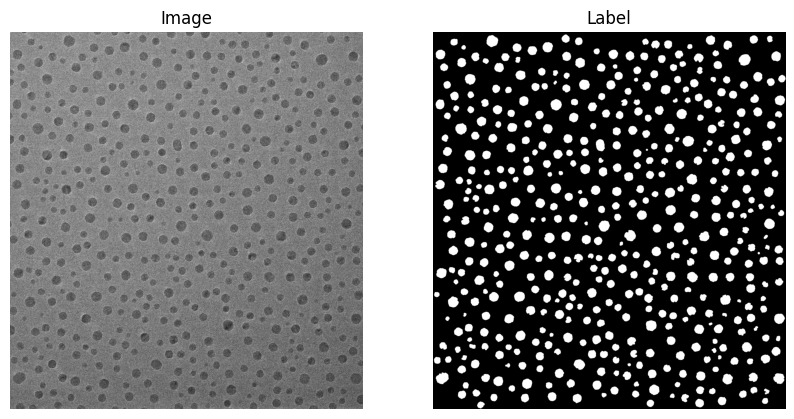

In [20]:
# Verify the shape of the data
print(f"images.shape: {images.shape}")
print(f"labels.shape: {labels.shape}")

# Normalize image data
images = images.astype(np.float32) / 255.0

# Visualize the first of the images and labels
# Plot two images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[0], cmap='gray')
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels[0], cmap='gray')
plt.title("Label")
plt.axis('off')

plt.show()

In [21]:
# Split the images into subimages of 128x128 pixels

# Ensure the dimensions are divisible by 128
assert images.shape[1] % 128 == 0 and images.shape[2] % 128 == 0, "Image dimensions must be divisible by 128."

# Reshape the images into subimages
subimages = images.reshape(
	images.shape[0], 
	images.shape[1] // 128, 
	128, 
	images.shape[2] // 128, 
	128
).transpose(0, 1, 3, 2, 4).reshape(-1, 128, 128)

# Reshape the labels into sublabels
sublabels = labels.reshape(
	labels.shape[0], 
	labels.shape[1] // 128, 
	128, 
	labels.shape[2] // 128, 
	128
).transpose(0, 1, 3, 2, 4).reshape(-1, 128, 128)

Before proceeding any further, we must verify that our data set actually has the shape `[3150, 128, 128]`. Both `images` and `labels` must share the same shape.

images.shape: (3150, 128, 128)
labels.shape: (3150, 128, 128)


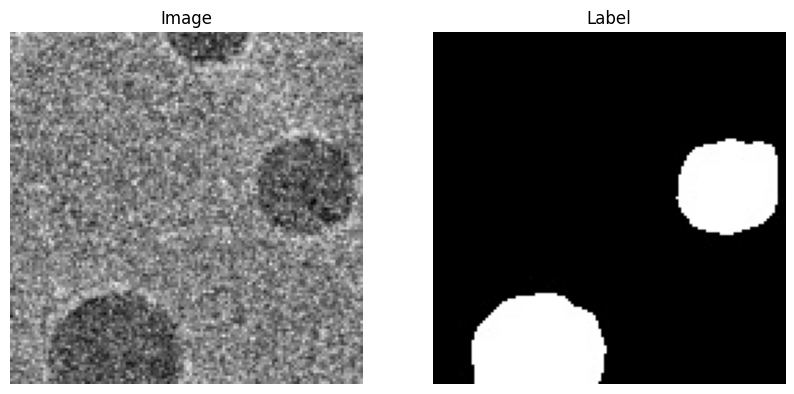

In [22]:
# Verify the shape of the data
print(f"images.shape: {subimages.shape}")
print(f"labels.shape: {sublabels.shape}")

# Visualize the first of the images and labels
# Plot two images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(subimages[0], cmap='gray')
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sublabels[0], cmap='gray')
plt.title("Label")
plt.axis('off')

plt.show()


In [23]:
# Create a training set and a test set
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    subimages, 
    sublabels, 
    test_size=0.2, 
    random_state=42
)
# Verify the shape of the data
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (2520, 128, 128)
y_train.shape: (2520, 128, 128)
X_test.shape: (630, 128, 128)
y_test.shape: (630, 128, 128)


## 2. Settings and hyperparameters

Our optimization algorithm is the ADAptive Moment estimation, [Adam](https://arxiv.org/pdf/1412.6980.pdf), that is based on stochastic gradient descent.

The number of **epochs** is the number of times the learning algorithm will work through the entire training dataset.

The **batch size** is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

We will use the Cross Entropy **loss function**.

In [14]:
from model import CNN_Segmenter
import torch
from torch.utils.data import DataLoader, TensorDataset

# Training parameters
learnig_rate = 2e-3
weight_decay = 0 # 1e-6

epochs       = 40
batch_size   = 100

# Define neural network
model = CNN_Segmenter()

# Prepare training data
X_train_tensor = torch.tensor(X_train).float().unsqueeze(1)
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

# Instantiate model
optimizer = torch.optim.Adam(model.parameters(), lr=learnig_rate, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.0))


In [ ]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


Epoch 1/40 - Loss: 45.9657
Epoch 2/40 - Loss: 41.9644
Epoch 3/40 - Loss: 41.3690
Epoch 4/40 - Loss: 41.3315
Epoch 5/40 - Loss: 41.2792
Epoch 6/40 - Loss: 41.2573
Epoch 7/40 - Loss: 41.2861
Epoch 8/40 - Loss: 41.2414
Epoch 9/40 - Loss: 41.2576
Epoch 10/40 - Loss: 41.1966
Epoch 11/40 - Loss: 41.2325
Epoch 12/40 - Loss: 41.1724
Epoch 13/40 - Loss: 41.1910
Epoch 14/40 - Loss: 41.1321
Epoch 15/40 - Loss: 41.1383
Epoch 16/40 - Loss: 41.0540
Epoch 17/40 - Loss: 40.9230
Epoch 18/40 - Loss: 40.7336
Epoch 19/40 - Loss: 39.9430
Epoch 20/40 - Loss: 35.8750
Epoch 21/40 - Loss: 26.7996
Epoch 22/40 - Loss: 22.5277
Epoch 23/40 - Loss: 20.6572
Epoch 24/40 - Loss: 18.7661
Epoch 25/40 - Loss: 17.4570
Epoch 26/40 - Loss: 17.3621
Epoch 27/40 - Loss: 17.5959
Epoch 28/40 - Loss: 17.0220
Epoch 29/40 - Loss: 17.0965
Epoch 30/40 - Loss: 16.8821
Epoch 31/40 - Loss: 16.7532
Epoch 32/40 - Loss: 17.7986
Epoch 33/40 - Loss: 17.1391
Epoch 34/40 - Loss: 17.1595
Epoch 35/40 - Loss: 16.3870
Epoch 36/40 - Loss: 16.5245
E

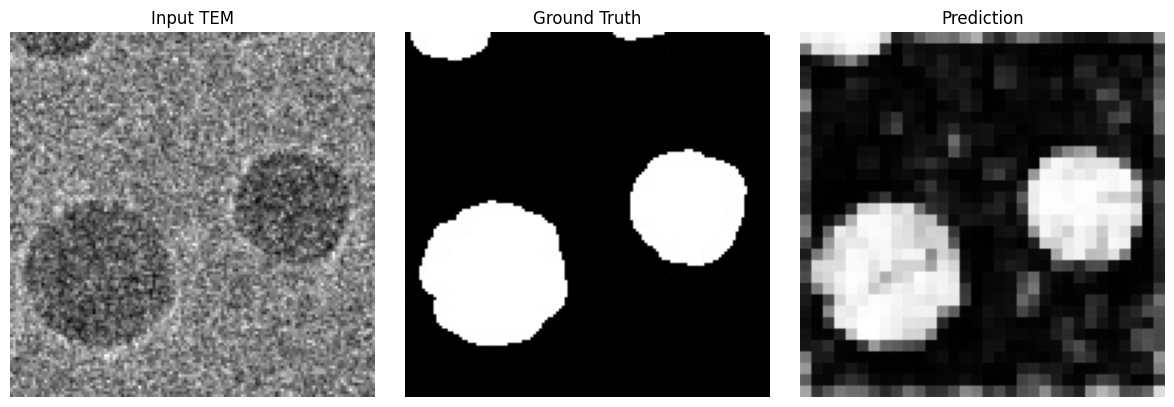

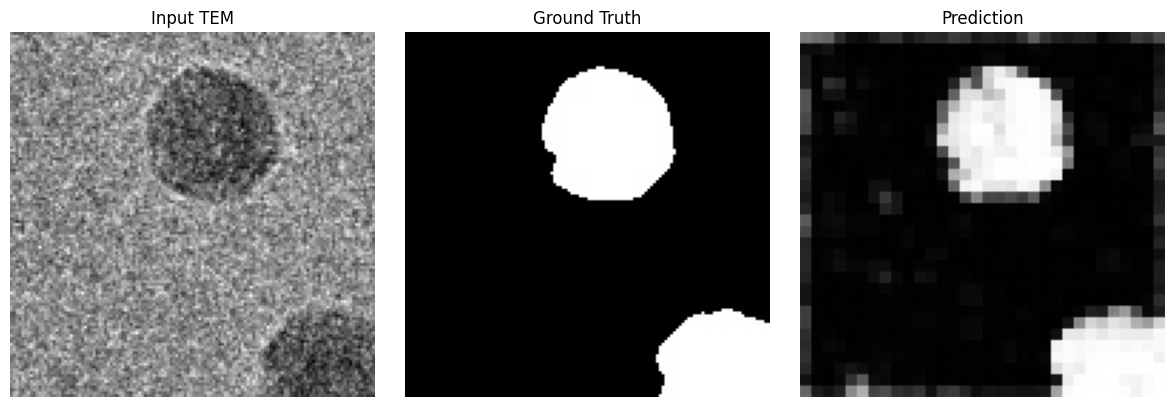

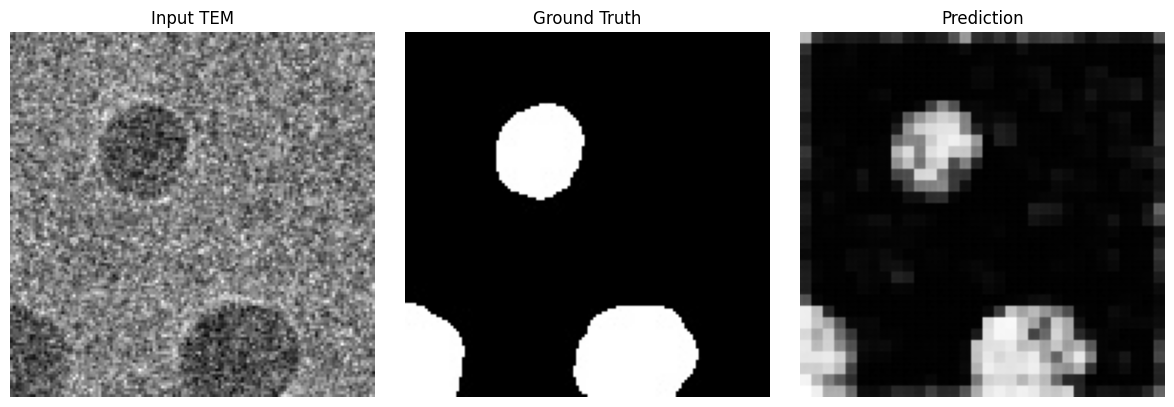

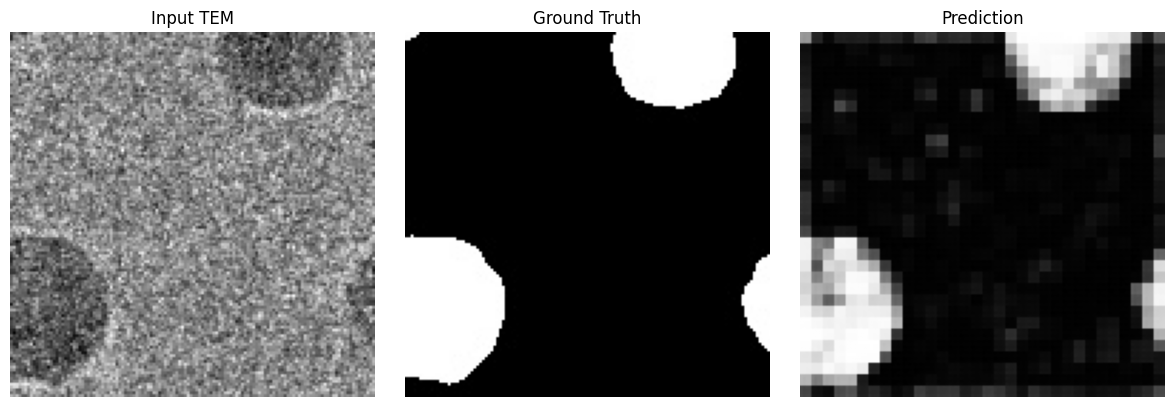

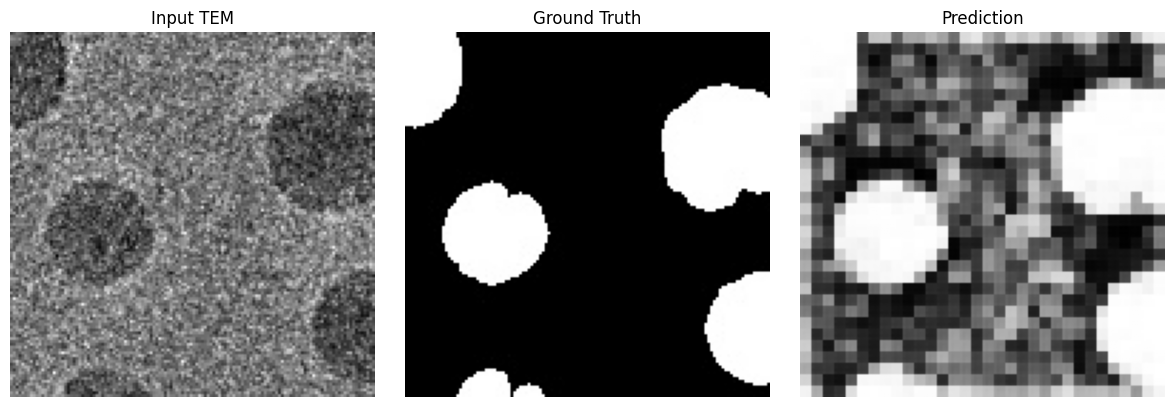

In [16]:
# Prepare test data
X_test_tensor = torch.tensor(X_test).float().unsqueeze(1)
y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=1)

# Evaluate and visualize
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # Select five random samples from the test set
    for i in range(5):
        idx = np.random.randint(0, len(X_test_tensor))
        xb = X_test_tensor[idx].unsqueeze(0)
        yb = y_test_tensor[idx].unsqueeze(0)
        pred_logits = model(xb)
        preds = torch.sigmoid(pred_logits)
        #preds = (preds > 0.5).float()
    
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(xb.squeeze(), cmap='gray')
        axs[0].set_title("Input TEM")
        axs[1].imshow(yb.squeeze(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds.squeeze(), cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()
        #break  # show just one example


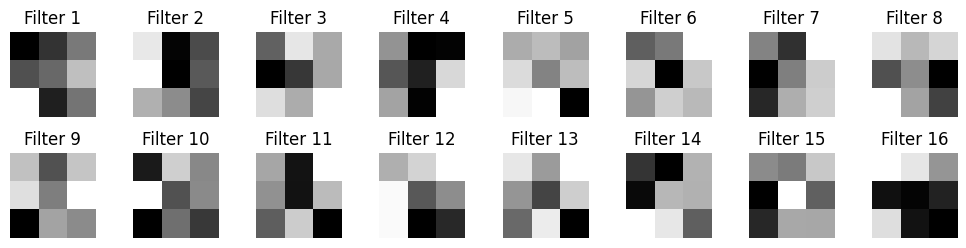

In [17]:
# Plot trained convolutional filters of the CNN_Segmenter

plt.figure(figsize=(10, 5))
for i, filter in enumerate(model.encoder[0].weight.data):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filter[0].detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Filter {i+1}")
plt.tight_layout()
plt.show()
